# Chapter 19: Dynamic Graph Theory Techniques for Node Ranking and Social Network Analysis

## 19.1 Uncovering Central Nodes based on Expected Traffic in a Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def add_random_edge(G, node1, node2, prob_road=0.9, mean_drive_time=20):
    if np.random.binomial(1, prob_road):
        drive_time = np.random.normal(mean_drive_time)
        G.add_edge(node1, node2, travel_time=round(drive_time, 2))

def add_intercountry_edges(G):
    nodes = list(G.nodes(data=True))
    for node1, attributes1 in nodes[:-1]:
        country1 = attributes1['country_id']
        for node2, attributes2 in nodes[node1:]:
            if country1 != attributes2['country_id']:
                add_random_edge(G, node1, node2, prob_road=0.05, mean_drive_time=45)
    
    return G

def random_country(country_id):
    numTowns = np.random.randint(3, 10)
    G = nx.Graph()
    nodes = [(node_id, {'country_id': country_id}) for node_id in range(numTowns)]
    G.add_nodes_from(nodes)
    for node1, _ in nodes[:-1]:
        for node2, _ in nodes[node1 + 1:]:
            add_random_edge(G, node1, node2)

    return G

<class 'int'>


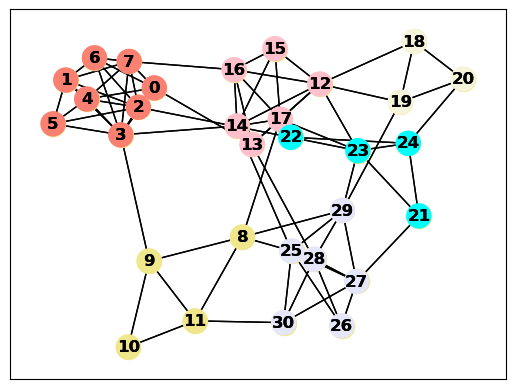

In [3]:
np.random.seed(1)
G = random_country(0)
for country_id in range(1, 6):
    G2 = random_country(country_id)
    G = nx.disjoint_union(G, G2)

G = add_intercountry_edges(G)
np.random.seed(1)
nx.draw_networkx(G, with_labels=True, node_color='khaki')

np.random.seed(1)
country_colors = ['salmon', 'khaki', 'pink', 'beige', 'cyan', 'lavender']
country_ids = [G.nodes[n]['country_id'] for n in G.nodes]
print(type(country_ids[0]))
node_colors = [country_colors[id_] for id_ in country_ids]
nx.draw_networkx(G, with_labels=True, node_color=node_colors)
plt.show() 

In [4]:
# Computing the degree of a single node
adjacency_matrix = nx.to_numpy_array(G)
degree_town_0 = adjacency_matrix[:,0].sum()
assert degree_town_0 == len(G[0])
assert degree_town_0 == G.degree(0)
print(f"Town 0 is connected by {degree_town_0:.0f} roads.")

Town 0 is connected by 5 roads.


* **Degee of Centrality**: Ranked importance of a node's degree

Town 3 is our most central town. It has 9 connecting roads.


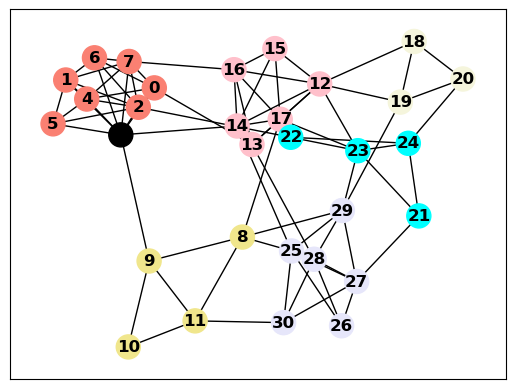

In [5]:
# Selecting a central node using degree of centrality
np.random.seed(1)
central_town = adjacency_matrix.sum(axis=0).argmax()
degree = G.degree(central_town)
print(f"Town {central_town} is our most central town. It has {degree} connecting roads.")
node_colors[central_town] = 'k'
nx.draw_networkx(G, with_labels=True, node_color=node_colors)
plt.show()

In [6]:
# Selecting a node with the second-highest degree of centrality
second_town = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[1]
second_degree = G.degree(second_town)
print(f"Town {second_town} has {second_degree} connecting roads.")

Town 12 has 8 connecting roads.


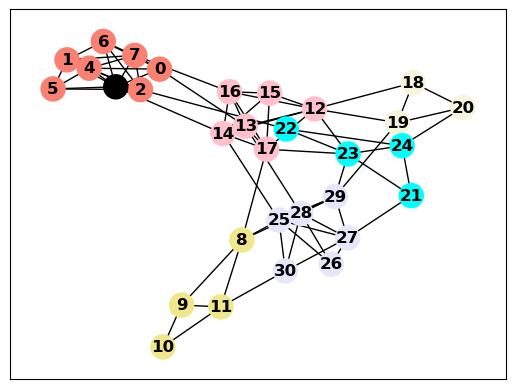

In [7]:
# Removing an edge from the most central node
np.random.seed(1)
G.remove_edge(3, 9)
assert G.degree(3) == G.degree(12)
nx.draw_networkx(G, with_labels=True, node_color=node_colors)
plt.show()

### 19.1.1 Measuring Centrality Using Traffic Simulations

In [8]:
# Simulating the random routes of a single car
np.random.seed(0)
def random_drive(num_stops=10):
    town = np.random.choice(G.nodes)
    for _ in range(num_stops):
        town = np.random.choice(G[town])
    
    return town

destination = random_drive()
print(f"After driving randomly, the car has reached Town {destination}.")

After driving randomly, the car has reached Town 24.


In [9]:
# Simulating traffic using 20,000 cars
import time
np.random.seed(0)
car_counts = np.zeros(len(G.nodes))
num_cars = 20000

start_time = time.time()
for _ in range(num_cars):
    destination = random_drive()
    car_counts[destination] += 1

central_town = car_counts.argmax()
traffic = car_counts[central_town]
running_time = time.time() - start_time
print(f"We ran a {running_time:.2f} second simulation.")
print(f"Town {central_town} has the most traffic.")
print(f"There are {traffic:.0f} cars in that town.")

We ran a 3.78 second simulation.
Town 12 has the most traffic.
There are 1015 cars in that town.


In [10]:
# Checking the traffic in Town 3
print(f"There are {car_counts[3]:.0f} cars in Town 3.")

There are 934 cars in Town 3.


In [11]:
# Converting traffic counts to probabilities
probabilities = car_counts / num_cars
for i in [12, 3]:
    prob = probabilities[i]
    print(f"The probability of winding up in Town {i} is {prob:.3f}.")

The probability of winding up in Town 12 is 0.051.
The probability of winding up in Town 3 is 0.047.


## 19.2 Computing Travel Probabilities Using Matrix Multiplication

In [13]:
# Computing the probability of travel to a neighboring town
num_neighbors = G.degree(0)
prob_travel = 1 / num_neighbors
print(f"The probability of traveling from Town 0 to one of its {G.degree(0)} neighboring towns is {prob_travel}")

The probability of traveling from Town 0 to one of its 5 neighboring towns is 0.2


In [15]:
# Computing a transition vector
transition_vector = np.array([0.2 if i in G[0] else 0 for i in G.nodes])

adjacency_matrix = nx.to_numpy_array(G)
v2 = np.array([1 if i in G[0] else 0 for i in G.nodes]) *0.2
v3 = adjacency_matrix[:,0] * 0.2
v4 = adjacency_matrix[:,0] / adjacency_matrix[:,0].sum()

for v in [v2, v3, v4]:
    assert np.array_equal(transition_vector, v)

print(transition_vector)

[0.  0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [19]:
# Computing a transition matrix
transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
assert np.array_equal(transition_vector, transition_matrix[:,0])

In [21]:
# Computing travel probabilities using the transition matrix
v = np.ones(31) / 31
for _ in range(10):
    v = transition_matrix @ v

for i in [12, 3]:
    print(f"The probability of winding up in Town {i} is {v[i]:.3f}.")

The probability of winding up in Town 12 is 0.051.
The probability of winding up in Town 3 is 0.047.


### 19.2.1 Deriving PageRank Centrality from Probability Theory

In [ ]:
# Computing a travel likelihood from a random starting location